## nn.vmap

In [31]:
import jax
import numpy as np
import jax.numpy as jnp

from optical_flax.layers import DSP_Model
from commplax.module import core
from optical_flax.utils import show_tree
import flax.linen as nn
Signal = core.Signal

key = jax.random.PRNGKey(0)
x0 =  jnp.ones([10000,2])
x1 = jnp.ones([3,10000,2])

In [32]:
var_axes = {'params':None, 'const':None, 'norm':0, 'af_state':0, 'aux_inputs':0}
rng_axes = {'params':False, 'const':False, 'norm':False, 'af_state':False, 'aux_inputs':False}
DSP_vmap = nn.vmap(DSP_Model,variable_axes=var_axes, split_rngs=rng_axes, in_axes=0, out_axes=0)
net = DSP_vmap()
var = net.init(key, Signal(x1))

z =net.apply(var, Signal(x1), mutable={'af_state','norm'})
show_tree(z[0])

Signal(val=(3, 4505, 2), t=SigTime(start=247, stop=-248, sps=1))

## data

In [33]:
from optical_flax.generate_data import get_data
train_path = f'data/data0426_N4e5/dataset_ch{25}_dz0.5_N4e5'
data = get_data(train_path, sps=2)
print(data.x.shape)

(100000, 2)


## split training

In [41]:
from optical_flax.layers import fdbp
from optical_flax.initializers import fdbp_init, gauss
from optical_flax.utils import realize
import flax.linen as nn

d_init,n_init = fdbp_init(data.a, xi=1.1, steps=3,domain='time')

class MyDBP(nn.Module):
    
    @nn.compact
    def __call__(self, signal):
        signal = fdbp(d_init=d_init, n_init=n_init)(signal)
        x,t = signal
        x = nn.Conv(features=2,kernel_size=(32,),strides=(2,),kernel_init=gauss, param_dtype=jnp.complex64,dtype=jnp.complex64, padding='same')(x)
        t = core.SigTime(t.start//2, t.stop//2, 1)
        return core.Signal(x,t)
        
DBP = MyDBP()
realdbp = realize(DBP)

var = realdbp.init(key, core.Signal(jnp.ones([1000,2])))
const = var['const']

def loss_fn(param,x,y, const):
    var = {'params':param, 'const':const}
    z = realdbp.apply(var, core.Signal(y))
    loss = jnp.mean(jnp.abs(z.val - x[z.t.start:z.t.stop])**2)
    return loss

import optax
tx = optax.adam(learning_rate=0.001)

@jax.jit
def update_state(param, x, y, const, opt_state):
    loss, grads =jax.value_and_grad(loss_fn)(param,x,y, const)
    updates, opt_state = tx.update(grads, opt_state)
    param = optax.apply_updates(param, updates)
    return loss, param, opt_state

In [42]:
param = var['params']
opt_state = tx.init(param)

from optical_flax.base import get_train_batch
from tqdm.auto import tqdm
loss_list = []
for j in tqdm(range(10), total=10, desc='Trainig', leave=False):
    loss, param, opt_state = update_state(param, data.x, data.y, const, opt_state)
    loss_list.append(loss)
    # n_batch, batch_gen = get_train_batch(data, 2000, 1000)
    # for i, (y, x) in enumerate(batch_gen):
    #     loss, param, opt_state = update_state(param, x, y, const, opt_state)
    # loss_list.append(loss)

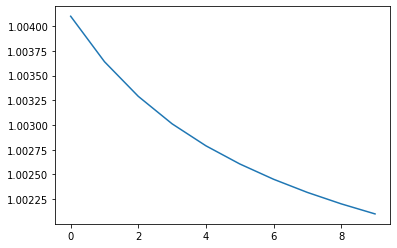

In [43]:
import matplotlib.pyplot as plt
plt.plot(loss_list)